Modelo analítico del chubasco electromagnético - Bethe-Heitler

    Generación  N_partículas  Energía_por_partícula (MeV)
0            0             1                  1000.000000
1            1             2                   500.000000
2            2             4                   250.000000
3            3             8                   125.000000
4            4            16                    62.500000
5            5            32                    31.250000
6            6            64                    15.625000
7            7           128                     7.812500
8            8           256                     3.906250
9            9           512                     1.953125
10          10             0                          NaN

t_max continuo ≈ 9.966
t_max entero   = 9
N máximo teórico ≈ 1000.0


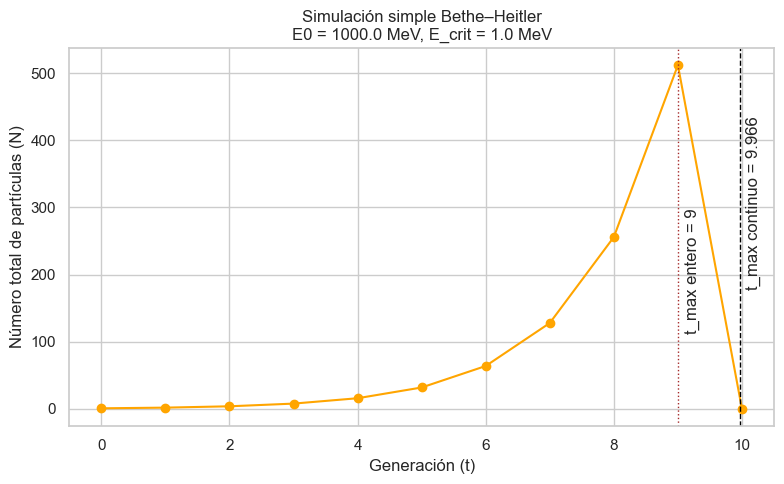

In [14]:
import math
import matplotlib.pyplot as plt
import pandas as pd

# Parámetros
E0_MeV = 1000.0       # Energía inicial (MeV)
E_crit_MeV = 1.0      # Umbral (MeV)
max_generations = 10  # Número máximo de generaciones

# Simulación
generations = []
particles = [E0_MeV]  # lista de energías de partículas

for gen in range(max_generations + 1):
    # Guardar info de la generación actual
    generations.append({
        "Generación": gen,
        "N_partículas": len(particles),
        "Energía_por_partícula (MeV)": particles[0] if len(particles) > 0 else None
    })
    
    # Crear la siguiente generación
    new_particles = []
    for e in particles:
        child_energy = e / 2.0
        if child_energy >= E_crit_MeV:
            new_particles.append(child_energy)
            new_particles.append(child_energy)
    particles = new_particles

# Convertir a DataFrame
df = pd.DataFrame(generations)
df["Energía_por_partícula (MeV)"] = df["Energía_por_partícula (MeV)"].round(6)
print(df)

# Cálculo del t_max teórico
t_max_continuo = math.log(E0_MeV/E_crit_MeV) / math.log(2)
t_max_entero = math.floor(t_max_continuo)
N_teorico = E0_MeV / E_crit_MeV
print(f"\nt_max continuo ≈ {t_max_continuo:.3f}")
print(f"t_max entero   = {t_max_entero}")
print(f"N máximo teórico ≈ {N_teorico}")

# Gráfica
plt.figure(figsize=(8,5))
plt.plot(df["Generación"], df["N_partículas"], marker='o', color="orange")
plt.xlabel("Generación (t)")
plt.ylabel("Número total de partículas (N)")
plt.title("Simulación simple Bethe–Heitler\n"
          f"E0 = {E0_MeV} MeV, E_crit = {E_crit_MeV} MeV")

# Líneas que muestran los t_max
plt.axvline(t_max_continuo, linestyle='--', linewidth=1, color="black")
plt.text(t_max_continuo+0.1, max(df["N_partículas"])*0.6, 
         f"t_max continuo = {t_max_continuo:.3f}", rotation=90, va='center')
plt.axvline(t_max_entero, linestyle=':', linewidth=1, color="brown")
plt.text(t_max_entero+0.1, max(df["N_partículas"])*0.4, 
         f"t_max entero = {t_max_entero}", rotation=90, va='center')

plt.grid(True)
plt.tight_layout()
plt.show()


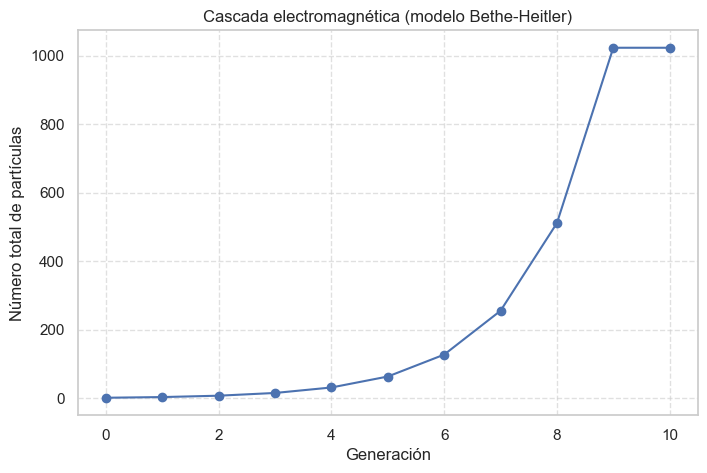

In [15]:
import matplotlib.pyplot as plt

# Parámetros de simulación
E0 = 1000.0  # Energía inicial del fotón (MeV)
Emin = 1.0   # Umbral mínimo de energía (MeV)
max_gen = 10 # Número máximo de generaciones

# Inicialización
generaciones = [0] * (max_gen + 1)  # número de partículas por generación
particulas = [(E0, 0)]  # lista de tuplas (energía, generación)

# Simulación
while particulas:
    E, g = particulas.pop(0)
    if g >= max_gen:
        continue
    if E < Emin:
        continue
    
    # La partícula se divide en dos con la mitad de la energía
    E_hija = E / 2
    particulas.append((E_hija, g + 1))
    particulas.append((E_hija, g + 1))
    
    # Contar
    generaciones[g] += 1

# Calcular número acumulado de partículas hasta cada generación
acumulado = []
total = 0
for g in generaciones:
    total += g
    acumulado.append(total)

# Gráfica
plt.figure(figsize=(8,5))
plt.plot(range(max_gen+1), acumulado, marker="o", linestyle="-", color="b")
plt.title("Cascada electromagnética (modelo Bethe-Heitler)")
plt.xlabel("Generación")
plt.ylabel("Número total de partículas")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


Simulación completada. Datos exportados y gráfico generado.


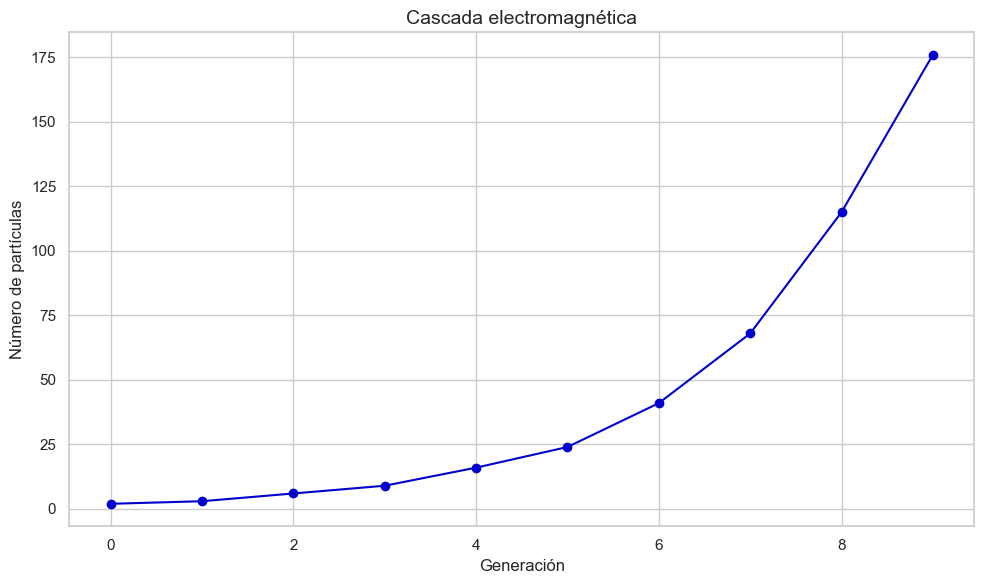

In [16]:
import random
import math
import csv
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Constantes
ELECTRON_MASS = 0.511  # MeV
MAX_GENERATIONS = 10
ANNIHILATION_PROB = 0.3

# Estilo de gráficos
sns.set(style="whitegrid")

# Clase de partícula
class Particle:
    def __init__(self, type, energy):
        self.type = type
        self.energy = energy

    def __repr__(self):
        return f"{self.type.capitalize()}({self.energy:.2f} MeV)"
# División aleatoria de energía
def random_split(energy):
    frac = random.uniform(0.3, 0.7)
    return (energy * frac, energy * (1 - frac))

# Simulación de la cascada
def simulate_shower(initial_energy, threshold):
    generation = 0
    particles = [Particle('gamma', initial_energy)]
    all_data = [ ]
    generation_counts = [ ]
    while particles and generation < MAX_GENERATIONS:
        new_particles = [ ]
        for p in particles:
            if p.energy < threshold:
                continue
            if p.type == 'gamma' and p.energy > 2 * ELECTRON_MASS:
                e_energy = random_split(p.energy)
                new_particles.append(Particle('electron', e_energy[0]))
                new_particles.append(Particle('positron', e_energy[1]))
            elif p.type == 'electron' and p.energy > threshold:
                gamma_energy = random_split(p.energy)[1]
                new_particles.append(Particle('gamma', gamma_energy))
                new_particles.append(Particle('electron', p.energy - gamma_energy))
            elif p.type == 'positron':
                if random.random() < ANNIHILATION_PROB:
                   new_particles.append(Particle('gamma', p.energy))
        generation_data = [(generation, p.type, p.energy) for p in new_particles]
        all_data.extend(generation_data)
        generation_counts.append(len(new_particles))
        particles = new_particles
        generation += 1
    return all_data, generation_counts

# Parámetros de simulación
initial_energy = 1000  # MeV
threshold = 1.0  # MeV

# Ejecutar simulación
data, counts = simulate_shower(initial_energy, threshold)

# Exportar datos a CSV
output_csv_path = "/mnt/data/shower_data.csv"
os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)
with open(output_csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Generación", "Tipo", "Energía (MeV)"])
    writer.writerows(data)

# Visualización del número de partículas por generación
plt.figure(figsize=(10, 6))
plt.plot(range(len(counts)), counts, marker='o', linestyle='-', color='mediumblue')
plt.xlabel("Generación", fontsize=12)
plt.ylabel("Número de partículas", fontsize=12)
plt.title("Cascada electromagnética", fontsize=14)
plt.grid(True)
plt.tight_layout()

# Guardar gráfico
plot_path = "/mnt/data/shower_plot.png"
plt.savefig(plot_path)
#plt.close()

print("Simulación completada. Datos exportados y gráfico generado.")




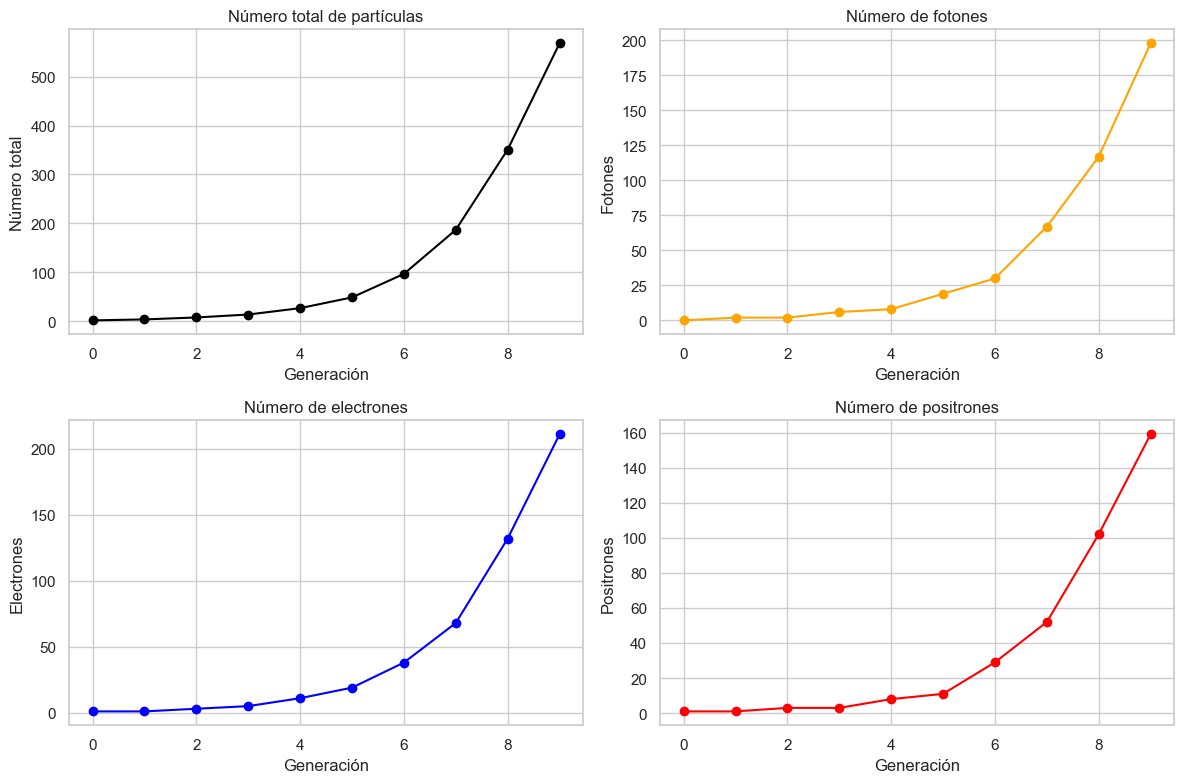

In [17]:
import random
import math
import csv
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Constantes
ELECTRON_MASS = 0.511  # MeV
MAX_GENERATIONS = 10
ANNIHILATION_PROB = 0.3

# Estilo de gráficos
sns.set(style="whitegrid")

# Clase de partícula
class Particle:
    def __init__(self, type, energy):
        self.type = type  # 'gamma', 'electron', 'positron'
        self.energy = energy

    def __repr__(self):
        return f"{self.type.capitalize()}({self.energy:.2f} MeV)"

# División aleatoria de energía
def random_split(energy):
    frac = random.uniform(0.3, 0.7)
    return (energy * frac, energy * (1 - frac))

# Simulación de la cascada
def simulate_shower(initial_energy, threshold):
    generation = 0
    particles = [Particle('gamma', initial_energy)]
    all_data = []
    
    # Listas de conteos
    total_counts = []
    gamma_counts = []
    electron_counts = []
    positron_counts = []
    
    while particles and generation < MAX_GENERATIONS:
        new_particles = []
        for p in particles:
            if p.energy < threshold:
                continue
            if p.type == 'gamma' and p.energy > 2 * ELECTRON_MASS:
                e_energy = random_split(p.energy)
                new_particles.append(Particle('electron', e_energy[0]))
                new_particles.append(Particle('positron', e_energy[1]))
            elif p.type == 'electron' and p.energy > threshold:
                gamma_energy, e_energy = random_split(p.energy)
                new_particles.append(Particle('gamma', gamma_energy))
                new_particles.append(Particle('electron', e_energy))
            elif p.type == 'positron':
                if random.random() < ANNIHILATION_PROB:
                    new_particles.append(Particle('gamma', p.energy))
                else:
                    # Positrón sigue perdiendo energía (ejemplo simple)
                    if p.energy > threshold:
                        gamma_energy, e_energy = random_split(p.energy)
                        new_particles.append(Particle('gamma', gamma_energy))
                        new_particles.append(Particle('positron', e_energy))
        
        # Guardar datos de la generación
        generation_data = [(generation, p.type, p.energy) for p in new_particles]
        all_data.extend(generation_data)
        
        # Conteos
        total_counts.append(len(new_particles))
        gamma_counts.append(sum(1 for p in new_particles if p.type == "gamma"))
        electron_counts.append(sum(1 for p in new_particles if p.type == "electron"))
        positron_counts.append(sum(1 for p in new_particles if p.type == "positron"))
        
        particles = new_particles
        generation += 1
    
    return all_data, total_counts, gamma_counts, electron_counts, positron_counts

# Parámetros de simulación
initial_energy = 1000.0  # MeV
threshold = 1.0  # MeV

# Ejecutar simulación
data, total_counts, gamma_counts, electron_counts, positron_counts = simulate_shower(initial_energy, threshold)

# Exportar datos a CSV
output_csv_path = "shower_data03.csv"
with open(output_csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Generación", "Tipo", "Energía (MeV)"])
    writer.writerows(data)

# --- Gráficas ---
gens = range(len(total_counts))

plt.figure(figsize=(12, 8))

# Gráfico 1: Total
plt.subplot(2,2,1)
plt.plot(gens, total_counts, marker='o', color='black')
plt.xlabel("Generación")
plt.ylabel("Número total")
plt.title("Número total de partículas")

# Gráfico 2: Fotones
plt.subplot(2,2,2)
plt.plot(gens, gamma_counts, marker='o', color='orange')
plt.xlabel("Generación")
plt.ylabel("Fotones")
plt.title("Número de fotones")

# Gráfico 3: Electrones
plt.subplot(2,2,3)
plt.plot(gens, electron_counts, marker='o', color='blue')
plt.xlabel("Generación")
plt.ylabel("Electrones")
plt.title("Número de electrones")

# Gráfico 4: Positrones
plt.subplot(2,2,4)
plt.plot(gens, positron_counts, marker='o', color='red')
plt.xlabel("Generación")
plt.ylabel("Positrones")
plt.title("Número de positrones")

plt.tight_layout()
plt.show()




Se observa que a medida que avanza la cascada, los electrones dominan en número, aunque los fotones se mantienen cercanos.

Los positrones aparecen en menor cantidad y con un retraso, debido a que requieren pares 
𝛾→𝑒−𝑒+γ→e−e+.

Esto concuerda con la física:

Los fotones iniciales producen pares electrón-positrón.

Los electrones y positrones generan radiación de frenado (bremsstrahlung), que produce más fotones.

Los positrones eventualmente se aniquilan, lo que limita su número

El modelo Bethe–Heitler captura la tendencia general (crecimiento de partículas hasta alcanzar un máximo cuando la energía por partícula cae bajo el umbral).

La simulación Monte Carlo muestra un comportamiento más rico y realista, con mayor número de partículas y diferenciación entre especies, reflejando la naturaleza probabilística de las interacciones electromagnéticas.

La comparación muestra cómo el modelo simple es útil para estimar la escala del fenómeno, mientras que la simulación Monte Carlo es esencial para describir la cascada en detalle.

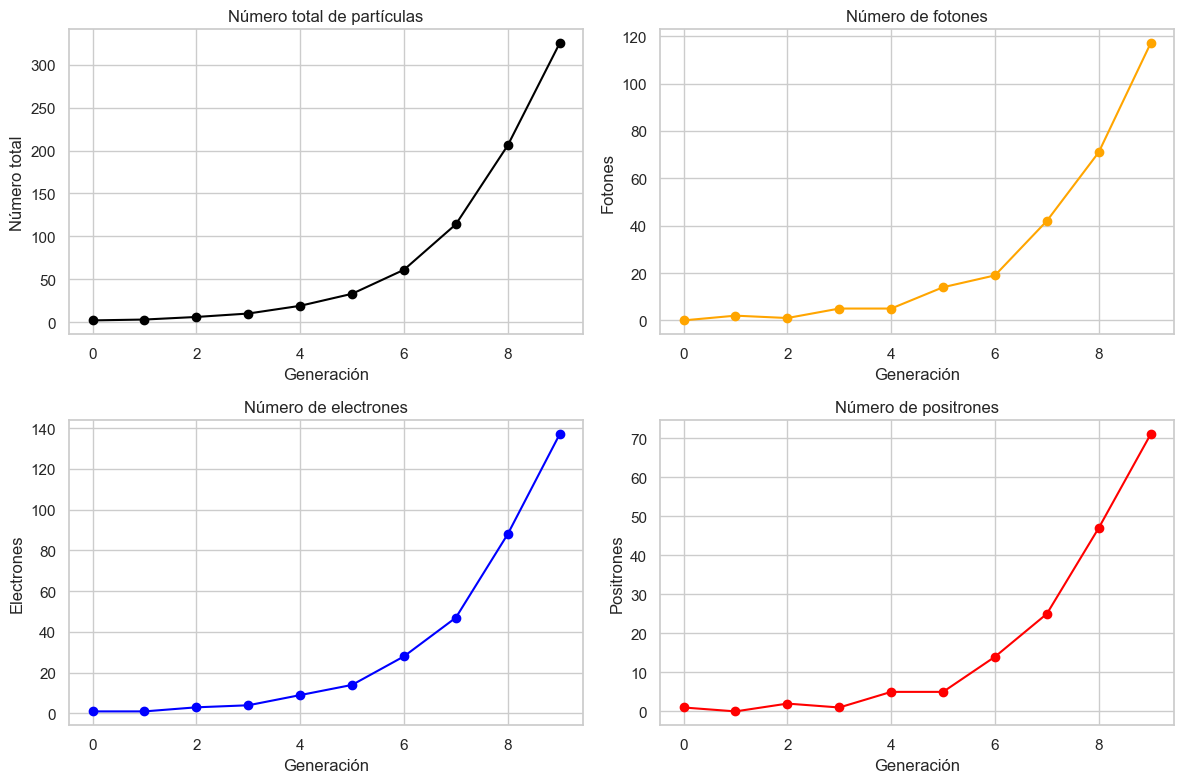

In [ ]:
import random
import math
import csv
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Constantes
ELECTRON_MASS = 0.511  # MeV
MAX_GENERATIONS = 10
ANNIHILATION_PROB = 0.8

# Estilo de gráficos
sns.set(style="whitegrid")

# Clase de partícula
class Particle:
    def __init__(self, type, energy):
        self.type = type  # 'gamma', 'electron', 'positron'
        self.energy = energy

    def __repr__(self):
        return f"{self.type.capitalize()}({self.energy:.2f} MeV)"

# División aleatoria de energía
def random_split(energy):
    frac = random.uniform(0.3, 0.7)
    return (energy * frac, energy * (1 - frac))

# Simulación de la cascada
def simulate_shower(initial_energy, threshold):
    generation = 0
    particles = [Particle('gamma', initial_energy)]
    all_data = []
    
    # Listas de conteos
    total_counts = []
    gamma_counts = []
    electron_counts = []
    positron_counts = []
    
    while particles and generation < MAX_GENERATIONS:
        new_particles = []
        for p in particles:
            if p.energy < threshold:
                continue
            if p.type == 'gamma' and p.energy > 2 * ELECTRON_MASS:
                e_energy = random_split(p.energy)
                new_particles.append(Particle('electron', e_energy[0]))
                new_particles.append(Particle('positron', e_energy[1]))
            elif p.type == 'electron' and p.energy > threshold:
                gamma_energy, e_energy = random_split(p.energy)
                new_particles.append(Particle('gamma', gamma_energy))
                new_particles.append(Particle('electron', e_energy))
            elif p.type == 'positron':
                if random.random() < ANNIHILATION_PROB:
                    new_particles.append(Particle('gamma', p.energy))
                else:
                    # Positrón sigue perdiendo energía (ejemplo simple)
                    if p.energy > threshold:
                        gamma_energy, e_energy = random_split(p.energy)
                        new_particles.append(Particle('gamma', gamma_energy))
                        new_particles.append(Particle('positron', e_energy))
        
        # Guardar datos de la generación
        generation_data = [(generation, p.type, p.energy) for p in new_particles]
        all_data.extend(generation_data)
        
        # Conteos
        total_counts.append(len(new_particles))
        gamma_counts.append(sum(1 for p in new_particles if p.type == "gamma"))
        electron_counts.append(sum(1 for p in new_particles if p.type == "electron"))
        positron_counts.append(sum(1 for p in new_particles if p.type == "positron"))
        
        particles = new_particles
        generation += 1
    
    return all_data, total_counts, gamma_counts, electron_counts, positron_counts

# Parámetros de simulación
initial_energy = 1000.0  # MeV
threshold = 1.0  # MeV

# Ejecutar simulación
data, total_counts, gamma_counts, electron_counts, positron_counts = simulate_shower(initial_energy, threshold)

# Exportar datos a CSV
output_csv_path = "shower_data08.csv"
with open(output_csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Generación", "Tipo", "Energía (MeV)"])
    writer.writerows(data)

# --- Gráficas ---
gens = range(len(total_counts))

plt.figure(figsize=(12, 8))

# Gráfico 1: Total
plt.subplot(2,2,1)
plt.plot(gens, total_counts, marker='o', color='black')
plt.xlabel("Generación")
plt.ylabel("Número total")
plt.title("Número total de partículas")

# Gráfico 2: Fotones
plt.subplot(2,2,2)
plt.plot(gens, gamma_counts, marker='o', color='orange')
plt.xlabel("Generación")
plt.ylabel("Fotones")
plt.title("Número de fotones")

# Gráfico 3: Electrones
plt.subplot(2,2,3)
plt.plot(gens, electron_counts, marker='o', color='blue')
plt.xlabel("Generación")
plt.ylabel("Electrones")
plt.title("Número de electrones")

# Gráfico 4: Positrones
plt.subplot(2,2,4)
plt.plot(gens, positron_counts, marker='o', color='red')
plt.xlabel("Generación")
plt.ylabel("Positrones")
plt.title("Número de positrones")

plt.tight_layout()
plt.show()




In [24]:
# Leer los dos archivos con encoding compatible
df_03 = pd.read_csv("shower_data03.csv", encoding="latin-1")
df_08 = pd.read_csv("shower_data08.csv", encoding="latin-1")

# Agrupar por generación → número total de partículas
count_03 = df_03.groupby("Generacion").size().reset_index(name="N_particulas")
count_08 = df_08.groupby("Generacion").size().reset_index(name="N_particulas")

# Gráfico comparativo
plt.figure(figsize=(8,5))
plt.plot(count_03["Generacion"], count_03["N_particulas"], marker='o', label="p_annih=0.3")
plt.plot(count_08["Generacion"], count_08["N_particulas"], marker='s', label="p_annih=0.8")
plt.xlabel("Generación")
plt.ylabel("Número total de partículas")
plt.title("Cascada electromagnética - Comparación de probabilidad de aniquilación")
plt.legend()
plt.grid(True)
plt.show()


KeyError: 'Generacion'